In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [16]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import toml
import joblib
import sleap_io as sio
import json
from tqdm.auto import tqdm
from qd_analysis.fig import setup_plotting_env
from qd_analysis.kpoints import get_pairwise_l2, get_pairwise_qd_l2
from segments import SegmentsClient

In [17]:
aliases = {
    "back_bottom": "Back bottom",
    "back_middle": "Back middle",
    "back_top": "Back top",
    "knee_L": "L. knee",
    "knee_R": "R. knee",
    "hindleg_L": "L. hindpaw",
    "hindleg_R": "R. hindpaw",
    "foreleg_L": "L. forepaw",
    "foreleg_R": "R. forepaw",
    "tail_base": "Tail base",
    "tail_middle": "Tail middle",
    "tail_tip": "Tail tip",
}

## User functions

# Get what already exists on segments

1. Get segments.ai labels, per labeled
1. Merge everything
1. Save per body part and per camera
1. Compare to fluo aligned data

In [18]:
def get_l2_norm(df, x1="x", y1="y", x2="x_segments", y2="y_segments"):
    return np.linalg.norm([df[x1] - df[x2], df[y1] - df[y2]])

In [19]:
config = toml.load("../preprocessing/config.toml")
data_dir = os.path.join(config["dirs"]["data"], "interlabeler_error")
fig_dir = "/storage/home/hcoda1/4/jmarkowitz30/shared_folder/active_lab_members/markowitz_jeffrey/panels/2025-04 (QD paper round 2)"

In [20]:
force = False
save_file = os.path.join(data_dir, "interlabeler_samples.pkl")

In [21]:
api_key = os.getenv("SEGMENTSAPI")
client = SegmentsClient(api_key)

In [22]:
dset_root_name = "jmarkow/basler-nir-plexiglass-arena-keypoints-fused-round2-reflectonly-"
dset_labelers = ["claire", "brittany", "zeynep", "amartya"]

if (not os.path.exists(save_file)) or force:
    labels = {}
    for _labeler in tqdm(dset_labelers):
        dset_name = f"{dset_root_name}{_labeler}"
        samples = client.get_samples(
            dset_name, per_page=10000, label_status=["LABELED", "REVIEWED"]
        )  # LABELED/REVIEWED
        labels[_labeler] = [(client.get_label(_sample.uuid), _sample) for _sample in samples]
    joblib.dump(labels, save_file)
else:
    labels = joblib.load(save_file)

In [23]:
segments_dset = client.get_dataset(f"{dset_root_name}{dset_labelers[0]}")
segments_cats = segments_dset.task_attributes.categories
segments_id_map = {_cat.id: _cat.name for _cat in segments_cats}

In [24]:
nlabels = {}
for k, v in labels.items():
    nlabels[k] = len(v)

In [25]:
# segments_dset_kneejoints = client.get_dataset(dset_name)
# segments_cats_kneejoints = segments_dset.task_attributes.categories
# segments_id_map_kneejoints = {_cat.id: _cat.name for _cat in segments_cats}

In [26]:
reference_labeler = max(nlabels, key=nlabels.get)
other_labelers = [_labeler for _labeler in dset_labelers if _labeler is not reference_labeler]

In [27]:
dfs = []
for k, v in labels.items():
    for _label in v:
        keypoints = _label[0].attributes.annotations
        img_path = _label[1].metadata["img_path"]
        xs = []
        ys = []
        names = []
        for _kpoint in keypoints:
            x, y = _kpoint.points[0]
            kpoint_name = segments_id_map[_kpoint.category_id]
            xs.append(x)
            ys.append(y)
            names.append(kpoint_name)
        _df = pd.DataFrame({"x": xs, "y": ys, "kpoint_name": names})
        _df["img_path"] = os.path.basename(img_path)
        _df["labeler"] = k
        dfs.append(_df)

In [28]:
kpoint_df = pd.concat(dfs, ignore_index=True)

In [29]:
kpoint_df_ave = kpoint_df.groupby(["img_path", "kpoint_name", "labeler"])[["x", "y"]].mean().reset_index()
pairwise_distances = kpoint_df_ave.groupby(["img_path", "kpoint_name"]).apply(get_pairwise_l2)

/tmp/ipykernel_244133/1956381827.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pairwise_distances = kpoint_df_ave.groupby(["img_path", "kpoint_name"]).apply(get_pairwise_l2)


# Keypoints relative to QDs

In [30]:
dset_name = "jmarkow/basler-nir-plexiglass-arena-keypoints-fused-round2"
save_file = os.path.join(data_dir, "interlabeler_samples_qd.pkl")

if (not os.path.exists(save_file)) or force:
    labels_qd = {}
    samples = client.get_samples(dset_name, per_page=10000, label_status=["LABELED", "REVIEWED"])  # LABELED/REVIEWED
    labels_qd = [(client.get_label(_sample.uuid), _sample) for _sample in samples]
    joblib.dump(labels_qd, save_file)
else:
    labels_qd = joblib.load(save_file)

In [31]:
segments_dset = client.get_dataset(dset_name)
segments_cats = segments_dset.task_attributes.categories
segments_id_cat_map = {_cat.id: _cat.name for _cat in segments_cats}
segments_cat_id_map = {v: k for k, v in segments_id_cat_map.items()}

In [36]:
# TODO COPY MANUAL LABELS!
qd_label_file = os.path.join(config["dirs"]["data"], "manually_labeled_keypoints/manual_label_standard-keypoints.slp")

In [37]:
labels_qd_slp = sio.load_file(qd_label_file).labeled_frames
labels_qd_slp_metadata = toml.load(qd_label_file.replace(".slp", ".toml"))["segments_metadata"]

In [38]:
for i, _metadata in enumerate(labels_qd_slp_metadata):
    # get matching segments metadata
    target_uuid = _metadata["uuid"]
    match_label = None
    for _label, _label_mdata in labels_qd:
        if _label.sample_uuid == _metadata["uuid"]:
            match_label = _label
    if match_label is not None:
        labels_qd_slp_metadata[i]["segments_label"] = match_label
    else:
        labels_qd_slp_metadata[i]["segments_label"] = None

In [39]:
dfs = []
for _label_slp, _metadata in zip(labels_qd_slp, labels_qd_slp_metadata):
    xs = []
    ys = []
    xs_segments = []
    ys_segments = []
    names = []
    _segments_annotations = _metadata["segments_label"].attributes.annotations
    _segments_points = {
        segments_id_cat_map[_annotation.category_id]: _annotation.points[0] for _annotation in _segments_annotations
    }
    for k, v in _label_slp.instances[0].points.items():
        # should exist in new file...
        kpoint_name = k.name
        x, y = v.x, v.y
        xs.append(x)
        ys.append(y)
        try:
            x_segments, y_segments = _segments_points[kpoint_name][0], _segments_points[kpoint_name][1]
        except KeyError:
            x_segments, y_segments = np.nan, np.nan
        xs_segments.append(x_segments)
        ys_segments.append(y_segments)
        names.append(kpoint_name)

    _df = pd.DataFrame({"x": xs, "y": ys, "x_segments": xs_segments, "y_segments": ys_segments, "kpoint_name": names})
    _df["img_path"] = os.path.basename(_metadata["img_path"])
    _df["labeler"] = "qd"
    _df["labeler_segments"] = _metadata["segments_label"].created_by
    dfs.append(_df)
    # pass

In [40]:
kpoint_qd_df = pd.concat(dfs, ignore_index=True)
kpoint_join_df = pd.concat([kpoint_df, kpoint_qd_df])
kpoint_labeler_average = (
    kpoint_join_df.query("labeler != 'qd'").groupby(["kpoint_name", "img_path"])[["x", "y"]].mean().reset_index()
)
kpoint_labeler_average["labeler"] = "labeler_average"
kpoint_join_df = pd.concat([kpoint_join_df, kpoint_labeler_average], ignore_index=True)

In [41]:
kpoint_qd_df["segments_to_qd_l2_error"] = kpoint_qd_df.apply(get_l2_norm, axis=1)

In [42]:
kpoint_join_df_ave = kpoint_join_df.groupby(["img_path", "kpoint_name", "labeler"])[["x", "y"]].mean().reset_index()
pairwise_distances_qd = kpoint_join_df_ave.groupby(["img_path", "kpoint_name"]).apply(get_pairwise_qd_l2)

/tmp/ipykernel_244133/2253549250.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pairwise_distances_qd = kpoint_join_df_ave.groupby(["img_path", "kpoint_name"]).apply(get_pairwise_qd_l2)


In [43]:
pairwise_distances_qd = pairwise_distances_qd.dropna()
pairwise_distances_qd = pairwise_distances_qd.apply(pd.Series)
pairwise_distances_qd_l2error = pairwise_distances_qd.map(np.linalg.norm)

In [44]:
pairwise_distances_qd_diff = pairwise_distances_qd.transform(lambda x: x - pairwise_distances_qd["labeler_average"])

# here we assume average displacement accounts for any bias in determining qd location
# what's left should be labeler jitter
pairwise_distances_qd_diff_l2_error = pairwise_distances_qd_diff.map(np.linalg.norm).drop("labeler_average", axis=1)

In [45]:
not_nans = (~pairwise_distances_qd.drop("labeler_average", axis=1).isnull()).sum(axis=1)
pairwise_distances_qd_diff_l2_error = pairwise_distances_qd_diff_l2_error.loc[not_nans > 1]

In [46]:
distances_labeler_to_qd = pairwise_distances_qd_l2error.dropna().apply(pd.Series)
cols = [_col for _col in distances_labeler_to_qd.columns if "average" not in _col]
replace_cols = {_col: f"reviewer_{i}" for i, _col in enumerate(cols)}
distances_labeler_to_qd = distances_labeler_to_qd.rename(columns=replace_cols)
distances_labeler_to_qd = distances_labeler_to_qd.melt(
    ignore_index=False, var_name="labeler", value_name="l2_error"
).reset_index()

In [47]:
plt_order = sorted(distances_labeler_to_qd["labeler"].unique())
plt_order = plt_order[1:] + plt_order[:1]

# Pairwise distances for knee joints

In [48]:
dset_root_name_kneejoints = "jmarkow/basler-nir-plexiglass-arena-keypoints-fused-kneejoints-reflectonly-"
dset_labelers_kneejoints = ["claire", "brittany", "zeynep", "amartya"]

In [49]:
save_file = os.path.join(data_dir, "interlabeler_samples_kneejoints.pkl")

In [50]:
if (not os.path.exists(save_file)) or force:
    labels_kneejoints = {}
    for _labeler in tqdm(dset_labelers_kneejoints):
        dset_name = f"{dset_root_name_kneejoints}{_labeler}"
        samples = client.get_samples(
            dset_name, per_page=10000, label_status=["LABELED", "REVIEWED"]
        )  # LABELED/REVIEWED
        labels_kneejoints[_labeler] = [(client.get_label(_sample.uuid), _sample) for _sample in samples]
    joblib.dump(labels_kneejoints, save_file)
else:
    labels_kneejoints = joblib.load(save_file)

In [51]:
segments_dset_kneejoints = client.get_dataset(f"{dset_root_name_kneejoints}{dset_labelers[0]}")
segments_cats_kneejoints = segments_dset_kneejoints.task_attributes.categories
segments_id_map_kneejoints = {_cat.id: _cat.name for _cat in segments_cats_kneejoints}

In [52]:
nlabels = {}
for k, v in labels.items():
    nlabels[k] = len(v)

In [53]:
reference_labeler = max(nlabels, key=nlabels.get)
other_labelers = [_labeler for _labeler in dset_labelers if _labeler is not reference_labeler]

In [54]:
list(labels.values())[0][1][1]

Sample(uuid='23590a73-8baa-4f7b-a14f-03bfa5e53961', name='session_20240610152529-475597_Basler-267601741000-24383488_1000.png-claire', attributes=ImageSampleAttributes(image=URL(url='https://segmentsai-prod.s3.eu-west-2.amazonaws.com/assets/jmarkow/0abe6097-14cc-4e7e-816d-d08d8db55635.png', signed_url=None)), metadata={'pad': 0, 'camera': 'Basler-267601741000-24383488', 'labeler': 'claire', 'img_path': '/storage/home/hcoda1/4/jmarkowitz30/shared_folder/active_lab_members/markowitz_jeffrey/active_projects/keypoints_basler_nir_plexiglass_arena/segments_ai_labeling_export_fused_round2_reflect_only/session_20240610152529-475597_Basler-267601741000-24383488_1000.png', 'frame_index': 1000, 'dat_path_fluo': '/home/jmarkow/data_dir/active_projects/quantum_dots/timecourse_02/session_20240610152529-475597 (system76-pc)/_proc/Basler-267601741000-24383488-fluorescence.avi', 'dat_path_reflect': '/home/jmarkow/data_dir/active_projects/quantum_dots/timecourse_02/session_20240610152529-475597 (system7

In [55]:
dfs = []
for k, v in labels_kneejoints.items():
    for _label in v:
        keypoints = _label[0].attributes.annotations
        img_path = _label[1].metadata["img_path"]
        xs = []
        ys = []
        names = []
        for _kpoint in keypoints:
            x, y = _kpoint.points[0]
            kpoint_name = segments_id_map_kneejoints[_kpoint.category_id]
            xs.append(x)
            ys.append(y)
            names.append(kpoint_name)
        _df = pd.DataFrame({"x": xs, "y": ys, "kpoint_name": names})
        _df["img_path"] = os.path.basename(img_path)
        _df["labeler"] = k
        dfs.append(_df)

In [56]:
kpoint_kneejoints_df = pd.concat(dfs, ignore_index=True)

In [57]:
kpoint_kneejoints_df_ave = (
    kpoint_kneejoints_df.groupby(["img_path", "kpoint_name", "labeler"])[["x", "y"]].mean().reset_index()
)
pairwise_distances_kneejoints = kpoint_kneejoints_df_ave.groupby(["img_path", "kpoint_name"]).apply(get_pairwise_l2)

/tmp/ipykernel_244133/1998460046.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pairwise_distances_kneejoints = kpoint_kneejoints_df_ave.groupby(["img_path", "kpoint_name"]).apply(get_pairwise_l2)


# Now repeat for kneejoints w/ qds...

In [58]:
dset_name = "jmarkow/basler-nir-plexiglass-arena-keypoints-fused-kneejoints"
save_file = os.path.join(data_dir, "interlabeler_samples_kneejoints_qd.pkl")
force = False
if (not os.path.exists(save_file)) or force:
    samples = client.get_samples(dset_name, per_page=10000, label_status=["LABELED", "REVIEWED"])  # LABELED/REVIEWED
    labels_qd_kneejoints = [(client.get_label(_sample.uuid), _sample) for _sample in samples]
    joblib.dump(labels_qd_kneejoints, save_file)
else:
    labels_qd_kneejoints = joblib.load(save_file)

In [59]:
segments_dset = client.get_dataset(dset_name)
segments_cats = segments_dset.task_attributes.categories
segments_id_cat_map = {_cat.id: _cat.name for _cat in segments_cats}
segments_cat_id_map = {v: k for k, v in segments_id_cat_map.items()}

In [60]:
qd_label_file_kneejoints = os.path.join(config["dirs"]["data"], "manually_labeled_keypoints/manual_label_kneejoints.slp")

In [61]:
labels_qd_kneejoints_slp = sio.load_file(qd_label_file_kneejoints).labeled_frames
labels_qd_kneejoints_slp_metadata = toml.load(qd_label_file_kneejoints.replace(".slp", ".toml"))["segments_metadata"]

In [62]:
segments_cat_id_map

{'knee_L': 1, 'knee_R': 2}

In [63]:
for i, _metadata in enumerate(labels_qd_kneejoints_slp_metadata):
    # get matching segments metadata
    target_uuid = _metadata["uuid"]
    match_label = None
    for _label, _label_mdata in labels_qd_kneejoints:
        if _label.sample_uuid == _metadata["uuid"]:
            match_label = _label
    if match_label is not None:
        labels_qd_kneejoints_slp_metadata[i]["segments_label"] = match_label
    else:
        labels_qd_kneejoints_slp_metadata[i]["segments_label"] = None

In [64]:
dfs = []
for _label_slp, _metadata in zip(labels_qd_kneejoints_slp, labels_qd_kneejoints_slp_metadata):
    xs = []
    ys = []
    xs_segments = []
    ys_segments = []
    names = []
    _segments_annotations = _metadata["segments_label"].attributes.annotations
    _segments_points = {
        segments_id_cat_map[_annotation.category_id]: _annotation.points[0] for _annotation in _segments_annotations
    }
    for k, v in _label_slp.instances[0].points.items():
        # should exist in new file...
        kpoint_name = k.name
        x, y = v.x, v.y
        xs.append(x)
        ys.append(y)
        try:
            x_segments, y_segments = _segments_points[kpoint_name][0], _segments_points[kpoint_name][1]
        except KeyError:
            x_segments, y_segments = np.nan, np.nan
        xs_segments.append(x_segments)
        ys_segments.append(y_segments)
        names.append(kpoint_name)

    _df = pd.DataFrame({"x": xs, "y": ys, "x_segments": xs_segments, "y_segments": ys_segments, "kpoint_name": names})
    _df["img_path"] = os.path.basename(_metadata["img_path"])
    _df["labeler"] = "qd"
    _df["labeler_segments"] = _metadata["segments_label"].created_by
    dfs.append(_df)
    # pass

In [65]:
kpoint_qd_kneejoints_df = pd.concat(dfs, ignore_index=True)
kpoint_join_kneejoints_df = pd.concat([kpoint_kneejoints_df, kpoint_qd_kneejoints_df])
kpoint_labeler_average = (
    kpoint_join_kneejoints_df.query("labeler != 'qd'")
    .groupby(["kpoint_name", "img_path"])[["x", "y"]]
    .mean()
    .reset_index()
)
kpoint_labeler_average["labeler"] = "labeler_average"
kpoint_join_kneejoints_df = pd.concat([kpoint_join_kneejoints_df, kpoint_labeler_average], ignore_index=True)

In [66]:
kpoint_qd_kneejoints_df["segments_to_qd_l2_error"] = kpoint_qd_kneejoints_df.apply(get_l2_norm, axis=1)

In [67]:
kpoint_join_kneejoints_df_ave = (
    kpoint_join_kneejoints_df.groupby(["img_path", "kpoint_name", "labeler"])[["x", "y"]].mean().reset_index()
)
pairwise_distances_qd_kneejoints = kpoint_join_kneejoints_df_ave.groupby(["img_path", "kpoint_name"]).apply(
    get_pairwise_qd_l2
)

/tmp/ipykernel_244133/3335572796.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pairwise_distances_qd_kneejoints = kpoint_join_kneejoints_df_ave.groupby(["img_path", "kpoint_name"]).apply(


In [68]:
pairwise_distances_qd_kneejoints = pairwise_distances_qd_kneejoints.dropna()
pairwise_distances_qd_kneejoints = pairwise_distances_qd_kneejoints.apply(pd.Series)
pairwise_distances_qd_l2error_kneejoints = pairwise_distances_qd_kneejoints.map(np.linalg.norm)

In [69]:
# diff_mean = pairwise_distances_qd.groupby("kpoint_name").mean()
pairwise_distances_qd_diff_kneejoints = pairwise_distances_qd_kneejoints.transform(
    lambda x: x - pairwise_distances_qd_kneejoints["labeler_average"]
)

# here we assume average displacement accounts for any bias in determining qd location
# what's left should be labeler jitter
pairwise_distances_qd_diff_l2_error_kneejoints = pairwise_distances_qd_diff_kneejoints.map(np.linalg.norm).drop(
    "labeler_average", axis=1
)

In [70]:
not_nans = (~pairwise_distances_qd_kneejoints.drop("labeler_average", axis=1).isnull()).sum(axis=1)
pairwise_distances_qd_diff_l2_error_kneejoints = pairwise_distances_qd_diff_l2_error_kneejoints.loc[not_nans > 1]

In [71]:
distances_labeler_to_qd_kneejoints = pairwise_distances_qd_l2error_kneejoints.dropna().apply(pd.Series)
cols = [_col for _col in distances_labeler_to_qd_kneejoints.columns if "average" not in _col]
replace_cols = {_col: f"reviewer_{i}" for i, _col in enumerate(cols)}
distances_labeler_to_qd_kneejoints = distances_labeler_to_qd_kneejoints.rename(columns=replace_cols)
distances_labeler_to_qd_kneejoints = distances_labeler_to_qd_kneejoints.melt(
    ignore_index=False, var_name="labeler", value_name="l2_error"
).reset_index()

In [72]:
plt_order = sorted(distances_labeler_to_qd_kneejoints["labeler"].unique())
plt_order = plt_order[1:] + plt_order[:1]

In [73]:
setup_plotting_env()

In [74]:
from scipy.stats import mode

In [75]:
stats = {"pairwise": {"mean": pairwise_distances_kneejoints.mean(), "median": pairwise_distances_kneejoints.median()}}

# Plotting everything together

In [76]:
# now combine back, tail, paws
segments = {}
segments["back"] = ["back_bottom", "back_middle", "back_top"]
segments["paws"] = ["foreleg_L", "foreleg_R", "hindleg_L", "hindleg_R"]
segments["tail"] = ["tail_base", "tail_middle", "tail_tip"]
segments["knee"] = ["knee_L", "knee_R"]
map_body_part_to_segment = {}
for k, v in segments.items():
    for _v in v:
        map_body_part_to_segment[_v] = k

In [77]:
stats = {
    "pairwise": dict(pairwise_distances.describe()),
    "pairwise_kneejoints": dict(pairwise_distances_kneejoints.describe()),
}

In [78]:
stats["to_qd"] = distances_labeler_to_qd.groupby("labeler")["l2_error"].agg(["mean", "median"]).to_dict()

In [79]:
pal = sns.color_palette("bright")
stats_colors = {"mean": pal[3], "median": pal[1], "50%": pal[1]}

In [80]:
plt_stats = ["mean", "50%"]

In [81]:
hist_kwargs = {
    "bins": np.arange(0, 26, 1),
    "element": "step",
    "alpha": 0.6,
    "clip_on": False,
    "fill": True,
    "linewidth": 0,
}

In [82]:
setup_plotting_env()

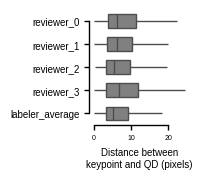

In [83]:
fig, ax = plt.subplots(1, figsize=(1.3, 1.5))
sns.boxplot(
    distances_labeler_to_qd,
    order=plt_order,
    y="labeler",
    x="l2_error",
    color=[0.5] * 3,
    width=0.6,
    showfliers=False,
    showcaps=False,
)
ax.set_ylabel("")
ax.tick_params(axis="y", which="major", labelsize=7)
ax.set_xlabel("Distance between\nkeypoint and QD (pixels)")
# ax.axvline(x=2.9)
sns.despine(trim=True)

In [84]:
plt_df = (
    pd.concat([pairwise_distances, pairwise_distances_kneejoints], ignore_index=False).rename("l2_error").reset_index()
)
# plt_df2 = pairwise_distances_kneejoints.rename("l2_error")
# plt_df = pairwise_distances.rename("l2_error").groupby(["img_path","kpoint_name"]).mean().dropna().reset_index()
nbody_parts = plt_df["kpoint_name"].nunique()
plt_df["segment"] = plt_df["kpoint_name"].map(map_body_part_to_segment)
plt_df["kpoint_name"] = plt_df["kpoint_name"].map(aliases)
nsegments = plt_df["segment"].nunique()

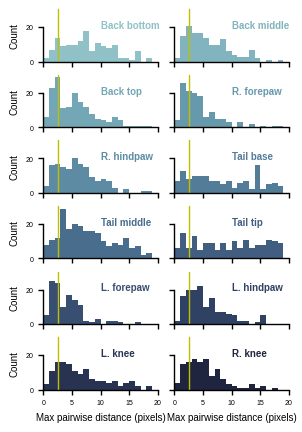

In [85]:
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(nbody_parts, rot=-0.25, light=0.7)
g = sns.FacetGrid(
    plt_df, col="kpoint_name", col_wrap=2, hue="kpoint_name", aspect=2, height=0.75, palette=pal, sharey=True
)
g.map(
    sns.histplot, "l2_error", bins=np.arange(0, 20, 1), element="step", clip_on=False, fill=True, alpha=1, linewidth=0
)
# g.map(sns.kdeplot, "l2_error", clip_on=False, color="w", lw=2, bw_adjust=0.5)
g.refline(x=2.5, linewidth=1, linestyle="-", color="y", clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(
        0.5,
        0.6,
        label,
        fontweight="bold",
        color=color,
        ha="left",
        va="bottom",
        transform=ax.transAxes,
    )


g.map(label, "kpoint_name")
g.figure.subplots_adjust(hspace=0.25)
g.set_titles("")
g.set(xlabel="Max pairwise distance (pixels)", xlim=(0, 20), xticks=np.arange(0, 25, 5))
# g.despine(bottom=True, left=True)
g.despine(trim=True)

In [86]:
median_error = plt_df.groupby("segment")["l2_error"].median()

In [87]:
median_error

segment
back     5.835452
knee     5.166883
paws     4.580240
tail    11.901269
Name: l2_error, dtype: float64

In [88]:
# config = toml.load("../preprocessing/config.toml")
save_file = os.path.join(config["dirs"]["analysis"], "sleap_metrics_qd_training.parquet")
# fig_dir = "/storage/home/hcoda1/4/jmarkowitz30/shared_folder/active_lab_members/markowitz_jeffrey/panels/2025-04 (QD paper round 2)"


autolabel_df = pd.read_parquet(save_file)

In [89]:
body_parts_cols = autolabel_df.filter(regex="test_dist.parts").columns
body_parts = [_part.split(".")[-1] for _part in body_parts_cols]

In [90]:
plt_points = autolabel_df.set_index(["is_joint", "condition", "nframes_train"])[body_parts_cols]
plt_points.columns = body_parts
plt_points = plt_points.melt(ignore_index=False, var_name="kpoint").reset_index()

In [91]:
plt_points["segment"] = plt_points["kpoint"].map(map_body_part_to_segment)

In [92]:
median_error_auto = (
    plt_points.query("condition=='all' and nframes_train>10000")
    .groupby("segment")["value"]
    .nsmallest(5)
    .groupby("segment")
    .median()
)

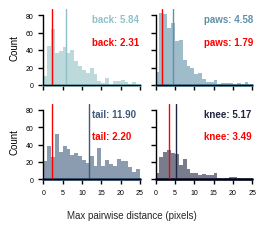

In [93]:
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(nsegments, rot=-0.25, light=0.7)
g = sns.FacetGrid(plt_df, col="segment", col_wrap=2, hue="segment", aspect=1.1, height=1.2, palette=pal, sharey=True)
g.map(
    sns.histplot,
    "l2_error",
    **hist_kwargs,
)
# g.map(sns.kdeplot, "l2_error", clip_on=False, color="w", lw=2, bw_adjust=0.5)
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    segment_median = median_error[label]
    segment_median_auto = median_error_auto[label]
    ax = plt.gca()
    ax.text(
        0.5,
        0.8,
        f"{label}: {segment_median:0.2f}",
        fontweight="bold",
        color=color,
        ha="left",
        va="bottom",
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        0.5,
        f"{label}: {segment_median_auto:0.2f}",
        fontweight="bold",
        color="r",
        # color=color,
        ha="left",
        va="bottom",
        transform=ax.transAxes,
    )
    ax.axvline(x=segment_median_auto, color="r")
    ax.axvline(x=segment_median, color=color)


g.map(label, "segment")
g.figure.subplots_adjust(hspace=0.25)
g.set_titles("")
g.set(xlabel="", xlim=(0, 25), xticks=np.arange(0, 26, 5))
g.fig.supxlabel("Max pairwise distance (pixels)", x=0.5, y=0.01, ha="center", fontsize=7)
# g.despine(bottom=True, left=True)
g.despine(trim=True)
g.fig.savefig(os.path.join(fig_dir, "interlabeler_distance_by_segment.pdf"), dpi=600, bbox_inches="tight")

In [94]:
# now show performance of QD-Pi alongside this...

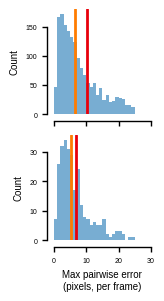

In [95]:
fig, ax = plt.subplots(2, 1, figsize=(1.25, 3.0), sharex=True, sharey=False)

sns.histplot(x=pairwise_distances, ax=ax[0], **hist_kwargs)
for _stat in plt_stats:
    ax[0].axvline(x=stats["pairwise"][_stat], color=stats_colors[_stat], lw=2)

sns.histplot(x=pairwise_distances_kneejoints, ax=ax[1], **hist_kwargs)
for _stat in plt_stats:
    ax[1].axvline(x=stats["pairwise_kneejoints"][_stat], color=stats_colors[_stat], lw=2)

ax[1].set_xlim(0, 30)
ax[1].set_xlabel("Max pairwise error\n(pixels, per frame)")
ax[0].set_ylabel("Count")
sns.despine(trim=True, offset=5)

In [96]:
# need to think about what we compare kneejoints to...

In [97]:
bins = np.arange(0, 30, 0.35)
kwargs = {
    "bins": bins,
    "stat": "percent",
    "element": "step",
    # "fill": True
}

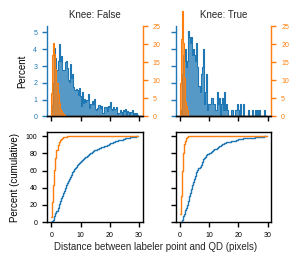

In [98]:
# DUAL Y AXIS
fig, ax = plt.subplots(2, 2, figsize=(3, 2.5), sharex=True, sharey="row")
second_axis_ylim = (0, 25)
for i, rax in enumerate(ax):
    cumulative = i > 0
    fill = not cumulative
    for j, ax1 in enumerate(rax):
        use_knee = j > 0
        color = "tab:blue"
        if use_knee:
            standard_kpoints = plt_df.query("kpoint_name.str.contains('knee')")["l2_error"]
            qd_kpoints = kpoint_qd_kneejoints_df["segments_to_qd_l2_error"]
        else:
            standard_kpoints = plt_df.query("~kpoint_name.str.contains('knee')")["l2_error"]
            qd_kpoints = kpoint_qd_df["segments_to_qd_l2_error"]

        sns.histplot(standard_kpoints, ax=ax1, color=color, fill=fill, cumulative=cumulative, clip_on=False, **kwargs)
        if not cumulative:
            ax1.tick_params(axis="y", labelcolor=color, color=color)
            ax1.spines["left"].set_color(color)

        color = "tab:orange"
        if not cumulative:
            ax2 = ax1.twinx()
        else:
            ax2 = ax1
        sns.histplot(qd_kpoints, ax=ax2, color=color, fill=fill, cumulative=cumulative, clip_on=False, **kwargs)
        if not cumulative:
            ax2.tick_params(axis="y", labelcolor=color, color=color)
            ax2.set_ylim(*second_axis_ylim)
            ax2.set_ylabel("")
            ax2.spines["right"].set_color(color)
            ax1.spines["top"].set_visible(False)
            ax1.spines["right"].set_visible(False)
            ax2.spines["left"].set_visible(False)
            ax2.spines["top"].set_visible(False)
        if i == 0:
            ax1.set_title(f"Knee: {use_knee}")
        ax1.set_xlabel("")

ax[-1][0].set_ylabel("Percent (cumulative)")
fig.tight_layout()
fig.supxlabel("Distance between labeler point and QD (pixels)", fontsize=7, ha="center", x=0.52, y=-0.01)
fig.savefig(os.path.join(fig_dir, "interlabeler_vs_qd_distance.pdf"), dpi=600, bbox_inches="tight")

In [99]:
# remap to reviewer names, let's show boxplots with
# their distance to qd without fluorescence? or
# distance to other labelers on same plot...
kpoint_qd_df.groupby("labeler_segments").size()

labeler_segments
amartya             220
brittanyaddison    2360
cdeng              4270
eulutas            1480
jmarkow              40
triesn              250
dtype: int64

In [100]:
kpoint_qd_df["segment"] = kpoint_qd_df["kpoint_name"].map(map_body_part_to_segment)

In [101]:
plt_qd_df = kpoint_qd_df[["segments_to_qd_l2_error", "labeler_segments", "img_path", "kpoint_name", "segment"]]

In [102]:
plt_qd_df = plt_qd_df.rename(columns={"labeler_segments": "labeler", "segments_to_qd_l2_error": "l2_error"})

In [103]:
plt_df["labeler"] = "pairwise"
plt_df["labeler_type"] = "manual"

In [104]:
plt_qd_df["labeler_type"] = "QD"
# plt_qd_df = plt_qd_df.groupby("labeler").filter(lambda x: len(x) > 50)

labeler_lst = sorted(plt_qd_df["labeler"].unique())
new_reviewer_name_map = {_name: f"Reviewer {i}" for i, _name in enumerate(labeler_lst)}

plt_qd_df["labeler"] = plt_qd_df["labeler"].map(new_reviewer_name_map)
combined_plt_df = pd.concat([plt_df, plt_qd_df], ignore_index=True)

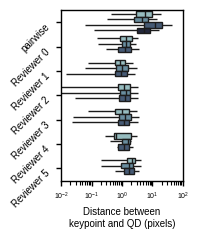

In [105]:
fig, ax = plt.subplots(1, figsize=(2, 2.4))
sns.boxplot(
    combined_plt_df,
    # order=plt_order,
    y="labeler",
    order=["pairwise"] + list(new_reviewer_name_map.values()),
    x="l2_error",
    hue="segment",
    palette=sns.cubehelix_palette(nsegments, rot=-0.25, light=0.7),
    # color=[.5]*3,
    legend=False,
    width=0.9,
    showfliers=False,
    showcaps=False,
)
ax.set_ylabel("")
ax.tick_params(axis="y", which="major", labelsize=7)
ax.set_xlabel("Distance between\nkeypoint and QD (pixels)")
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(ax.get_yticklabels(), rotation=45, va="top")
ax.set_xlim(0.01, 100)
# l = ax.legend()
# l.set(bbox_to_anchor=(1.05,.5))
# l = ax.legend()
# l.set(bbox_to_anchor=(1.5,.5))
# ax.axvline(x=2.9)
# sns.despine(trim=True)
ax.set_xscale("log")
fig.tight_layout()
fig.savefig(os.path.join(fig_dir, "interlabeler_vs_qd_distance_by_reviewer.pdf"), dpi=600)

In [106]:
# output stuff to toml file

In [107]:
stats["all_labelers_pairwise_not_knee_median"] = plt_df.query("~kpoint_name.str.contains('knee')")["l2_error"].median()
stats["all_labelers_pairwise_knee_median"] = plt_df.query("kpoint_name.str.contains('knee')")["l2_error"].median()
stats["all_labelers_pairwise_by_segment_median"] = plt_df.groupby("segment")["l2_error"].median().to_dict()
stats["all_labelers_to_qd_median"] = plt_qd_df["l2_error"].median()
stats["all_labelers_to_qd_by_segment_median"] = plt_qd_df.groupby("segment")["l2_error"].median().to_dict()
stats["all_labelers_to_qd_by_labeler_median"] = plt_qd_df.groupby("labeler")["l2_error"].median().to_dict()
stats["all_labelers_pairwise_nframes"] = (
    plt_df.dropna(subset=["l2_error"]).query("~kpoint_name.str.contains('knee')")["img_path"].nunique()
)
stats["all_labelers_pairwise_nframes_kneejoints"] = (
    plt_df.dropna(subset=["l2_error"]).query("kpoint_name.str.contains('knee')")["img_path"].nunique()
)
stats["all_labelers_pairwise_nlabelers"] = kpoint_df["labeler"].nunique()
stats["all_labelers_to_qd_nframes"] = kpoint_qd_df.dropna()["img_path"].nunique()
stats["all_labelers_to_qd_nlabelers"] = kpoint_qd_df.dropna()["labeler_segments"].nunique()

In [108]:
stats_fname = "keypoint_errors_stats.toml"
with open(os.path.join(fig_dir, stats_fname), "w") as f:
    toml.dump(stats, f)